# 7.4 随机森林

除了先构建一个BaggingClassifier然后将其传输到DecisionTreeClassifier，还有一种方法就是使用RandomForestClassifier类，这种方法更方便，对决策树更优化.

> 如果你想要对决策树之外的东西进行装袋（bag），BaggingClassifier还是有用的。


In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.40, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, len(X_train), len(X_test)


((400, 2), (400,), 400, 100)

In [3]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=16, splitter="random"), n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)


In [5]:
np.sum(y_pred_rf==y_pred_bag)/len(y_pred_bag)

0.91

除少数例外，RandomForestClassifier具有DecisionTreeClassifier的所有超参数（以控制树的生长方式），以及BaggingClassifier的所有超参数来控制集成本身.随机森林在树的生长上引入了更多的随机性：分裂节点时不再是搜索最好的特征（见第6章），而是在一个随机生成的特征子集里搜索最好的特征。这导致决策树具有更大的多样性，（再一次）用更高的偏差换取更低的方差，总之，还是产生了一个整体性能更优的模型。上面的的BaggingClassifier与RandomForestClassifier几乎相同。

## 7.4.1 极端随机树

在随机森林里单棵树的生长过程中，每个节点在分裂时仅考虑到了一个随机子集所包含的特征。如果我们对每个特征使用随机阈值，而不是搜索得出的最佳阈值（如常规决策树），则可能让决策树生长得更加随机。这种极端随机的决策树组成的森林称为**极端随机树集成（或简称Extra-Trees）**。同样，**它也是以更高的偏差换取了更低的方差**。

极端随机树训练起来比常规随机森林要快很多，因为在每个节点上找到每个特征的最佳阈值是决策树生长中最耗时的任务之一。使用Scikit-Learn的ExtraTreesClassifier类可以创建一个极端随机树分类器。它的API与RandomForestClassifier类相同。同理，ExtraTreesRegressor类与RandomForestRegressor类的API也相同。

**很难预先知道一个RandomForestClassifier类是否会比一个ExtraTreesClassifier类更好或是更差。唯一的方法是两种都尝试一遍，然后使用交叉验证（还需要使用网格搜索调整超参数）进行比较。**

## 7.4.2 特征重要性

**随机森林的另一个好特性是它们使测量每个特征的相对重要性变得容易。Scikit-Learn通过查看使用该特征的树节点平均（在森林中的所有树上）减少不纯度的程度来衡量该特征的重要性。更准确地说，它是一个加权平均值，其中每个节点的权重等于与其关联的训练样本的数量（见第6章）。**

Scikit-Learn会在训练后为每个特征自动计算该分数，然后对结果进行缩放以使所有重要性的总和等于1。你可以使用`feature_importances_`变量来访问结果




In [6]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10132818803091817
sepal width (cm) 0.024416753328541978
petal length (cm) 0.4058940741645153
petal width (cm) 0.46836098447602453


同样，如果在MNIST数据集上训练随机森林分类器并绘制每个像素的重要性.

In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)
mnist.target

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [8]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [10]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

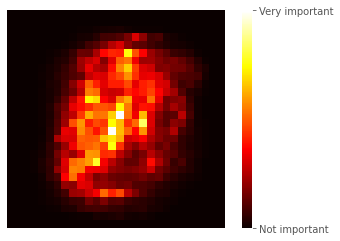

In [11]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

随机森林非常便于你快速了解哪些特征是真正重要的，特别是在需要执行特性选择时。